# Dependencies 

In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.contrib.tensorboard.plugins import projector
from global_config import RANDOM_SEED, IMAGE_SIZE
from local_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from utils import plot

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Autoencoder Unsupervised'
FOLDER_LOGS = '../../logs'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [4]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])


print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [5]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [6]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

# Model Training 

In [7]:
x_train, x_val, _, _ = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [8]:
def conv_bn(idx, prev_input, filters, name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = 'relu_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation('relu', name=act_name)(conv)
    return conv

def conv_bn_maxpool(idx, prev_input,  filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool

def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 5151 samples, validate on 580 samples
Epoch 1/100
5151/5151 [==============================] - 62s 12ms/step - loss: 0.0264 - val_loss: 0.0376

Epoch 00001: val_loss improved from inf to 0.03760, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 2/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0106 - val_loss: 0.0225

Epoch 00002: val_loss improved from 0.03760 to 0.02251, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 3/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0088 - val_loss: 0.0117

Epoch 00003: val_loss improved from 0.02251 to 0.01165, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 4/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0076 - val_loss: 0.0100

Epoch 00004: val_loss improved from 0.01165 to 0.01003, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 5/1

5151/5151 [==============================] - 56s 11ms/step - loss: 0.0026 - val_loss: 0.0039

Epoch 00044: val_loss did not improve from 0.00367
Epoch 45/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0025 - val_loss: 0.0035

Epoch 00045: val_loss improved from 0.00367 to 0.00346, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 46/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0024 - val_loss: 0.0034

Epoch 00046: val_loss improved from 0.00346 to 0.00344, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 47/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0024 - val_loss: 0.0033

Epoch 00047: val_loss improved from 0.00344 to 0.00328, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 48/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0024 - val_loss: 0.0037

Epoch 00048: val_loss did not impr

5151/5151 [==============================] - 56s 11ms/step - loss: 0.0019 - val_loss: 0.0033

Epoch 00092: val_loss did not improve from 0.00295
Epoch 93/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0018 - val_loss: 0.0032

Epoch 00093: val_loss did not improve from 0.00295
Epoch 94/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0018 - val_loss: 0.0033

Epoch 00094: val_loss did not improve from 0.00295
Epoch 95/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0017 - val_loss: 0.0029

Epoch 00095: val_loss improved from 0.00295 to 0.00294, saving model to ../../models/siamese_networks/model_2020_05_21-16_45_48.h5
Epoch 96/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0018 - val_loss: 0.0030

Epoch 00096: val_loss did not improve from 0.00294
Epoch 97/100
5151/5151 [==============================] - 56s 11ms/step - loss: 0.0018 - val_loss: 0.0032

Epoch 00097: val_loss did not improv

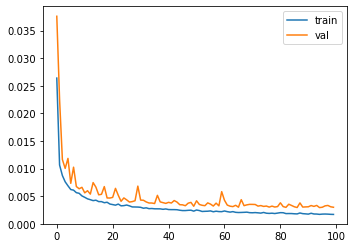

In [9]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
pool_5 = conv_bn_maxpool(5, pool_4, 256)
encode = conv_bn(6, pool_5, 512, name='encoded')

dec_5 = deconv_bn(5, encode, 256)
dec_4 = deconv_bn(4, dec_5, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

model = Model(inputs=inputs, outputs=decoded)
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

FILE_MODEL = FOLDER_MODELS + timestamp_model_name()
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor='val_loss', verbose=1, save_best_only=True), 
    EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(x_train, x_train, batch_size=32, epochs=100, validation_data=(x_val, x_val), callbacks=list_callbacks)
plot.keras_hist(hist.history)

In [10]:
model = load_model(FILE_MODEL)
y_pred = model.predict(x_val)

print(y_pred.shape, y_pred.dtype, y_pred.min(), y_pred.max())

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


(580, 160, 160, 3) float32 0.0 0.99999833


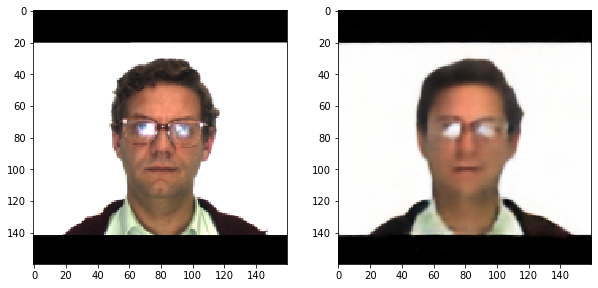

In [11]:
n_images = x_val.shape[0]
index = np.random.choice(range(n_images))

im_orig = x_val[index]
im_pred = y_pred[index]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_orig[:, :, ::-1])

plt.subplot(1, 2, 2)
plt.imshow(im_pred[:, :, ::-1])

# Embeddings Visualization 

### Metadata 

In [12]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

580
(580, 160, 160, 3)


In [13]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [14]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [15]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

(4000, 4000, 3)


### Embeddings 

In [16]:
model = load_model(FILE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

In [17]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(580, 512)


### Tensorboard 

In [18]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [19]:
mlflow.end_run()